# Notebook 4b: Advanced Dyadic Analysis - Poincaré & Leader-Follower

## Overview

This notebook extends Notebook 4 with specialized dyadic analyses:

1. **Dyadic Poincaré Plot Analysis** - Visualize beat-to-beat coordination
2. **Leader-Follower Analysis** - Identify directional influences
3. **Granger Causality** - Test for predictive relationships
4. **Directional Phase Synchrony** - Phase-based directionality

These methods help answer: **"Who is influencing whom?"**

---

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

from scipy import signal, stats
from scipy.signal import hilbert, correlate
import neurokit2 as nk

# Optional: statsmodels for Granger causality
try:
    from statsmodels.tsa.stattools import grangercausalitytests
    GRANGER_AVAILABLE = True
except ImportError:
    GRANGER_AVAILABLE = False
    print(" statsmodels not available for Granger causality")
    print("   Install with: pip install statsmodels")

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

print(" Libraries imported")

 Libraries imported


## 2. Load Data

We'll load:
- R-peak based heart rate from Notebook 3 (for leader-follower analysis)
- RR intervals from Notebook 3 (for Poincaré analysis)

In [2]:
# Load processed data
data_dir = Path("/Users/lena/Downloads/tutorial_dyadic_movesense/")

# Load metadata
with open(data_dir / 'processed_data/metadata.json', 'r') as f:
    metadata = json.load(f)

# Load heart rate data from Notebook 3 (R-peak based)
hr_p1 = pd.read_csv(data_dir / f"analysis_results/hr_rpeak_{metadata['participant_1']}.csv")
hr_p2 = pd.read_csv(data_dir / f"analysis_results/hr_rpeak_{metadata['participant_2']}.csv")

# Load RR intervals directly from Notebook 3
rr_p1_df = pd.read_csv(data_dir / f"analysis_results/rr_intervals_{metadata['participant_1']}.csv")
rr_p2_df = pd.read_csv(data_dir / f"analysis_results/rr_intervals_{metadata['participant_2']}.csv")

print(f"✓ Loaded data for {metadata['participant_1']} and {metadata['participant_2']}")
print(f"✓ Loaded {len(rr_p1_df)} RR intervals for P1")
print(f"✓ Loaded {len(rr_p2_df)} RR intervals for P2")

✓ Loaded data for Participant_A and Participant_B
✓ Loaded 845 RR intervals for P1
✓ Loaded 1001 RR intervals for P2


## 3. Dyadic Poincaré Plot Analysis

### What is a Dyadic Poincaré Plot?

**Individual Poincaré Plot**: RR(n) vs RR(n+1) for one person
- Shows beat-to-beat variability patterns
- Shape reveals autonomic regulation

**Dyadic Poincaré Plot**: RR₁(n) vs RR₂(n)
- Shows how participants' heart rates coordinate **at the same moments**
- Scatter close to identity line = tight coupling
- Correlation reveals strength of coordination

### What to Look For:
- **Strong correlation (r > 0.5)**: Hearts beating in sync
- **Points above/below line**: One person consistently faster/slower
- **Tight cluster**: Stable coordination
- **Wide scatter**: Variable/loose coordination

In [3]:
# Use RR intervals directly from Notebook 3
rr_p1 = rr_p1_df['RR_interval'].values
rr_p2 = rr_p2_df['RR_interval'].values

# Ensure same length
min_len = min(len(rr_p1), len(rr_p2))
rr_p1 = rr_p1[:min_len]
rr_p2 = rr_p2[:min_len]

print(f"✓ Using {min_len} RR intervals from R-peak detection")
print(f"  P1: mean={np.mean(rr_p1):.1f}ms, std={np.std(rr_p1):.1f}ms")
print(f"  P2: mean={np.mean(rr_p2):.1f}ms, std={np.std(rr_p2):.1f}ms")

✓ Using 845 RR intervals from R-peak detection
  P1: mean=637.3ms, std=130.1ms
  P2: mean=559.7ms, std=85.7ms


In [4]:
def dyadic_poincare_analysis(rr1, rr2):
    """
    Comprehensive dyadic Poincaré analysis.
    
    Returns:
    --------
    dict with:
        - correlation: Simultaneous RR correlation
        - lag1_p1_to_p2: P1's RR(n) predicts P2's RR(n+1)
        - lag1_p2_to_p1: P2's RR(n) predicts P1's RR(n+1)
        - mean_diff: Mean RR difference (P1 - P2)
        - std_diff: Std of differences
        - sd1_p1, sd2_p1: P1's Poincaré indices
        - sd1_p2, sd2_p2: P2's Poincaré indices
    """
    if len(rr1) != len(rr2):
        min_len = min(len(rr1), len(rr2))
        rr1 = rr1[:min_len]
        rr2 = rr2[:min_len]
    
    results = {}
    
    # Simultaneous correlation
    results['correlation'] = float(np.corrcoef(rr1, rr2)[0, 1])
    
    # Lag-1 cross-correlations (directionality)
    if len(rr1) > 2:
        # Does P1's current RR predict P2's next RR?
        results['lag1_p1_to_p2'] = float(np.corrcoef(rr1[:-1], rr2[1:])[0, 1])
        # Does P2's current RR predict P1's next RR?
        results['lag1_p2_to_p1'] = float(np.corrcoef(rr2[:-1], rr1[1:])[0, 1])
    else:
        results['lag1_p1_to_p2'] = np.nan
        results['lag1_p2_to_p1'] = np.nan
    
    # Difference metrics
    diff = rr1 - rr2
    results['mean_diff'] = float(np.mean(diff))
    results['std_diff'] = float(np.std(diff))
    
    # Individual Poincaré indices
    for i, rr in enumerate([rr1, rr2], 1):
        diff_rr = np.diff(rr)
        sd1 = np.sqrt(np.std(diff_rr, ddof=1) ** 2 * 0.5)
        sd2 = np.sqrt(2 * np.std(rr, ddof=1) ** 2 - 0.5 * np.std(diff_rr, ddof=1) ** 2)
        results[f'sd1_p{i}'] = float(sd1)
        results[f'sd2_p{i}'] = float(sd2)
    
    return results

# Compute analysis
poincare_results = dyadic_poincare_analysis(rr_p1, rr_p2)

print("=" * 70)
print("DYADIC POINCARÉ ANALYSIS")
print("=" * 70)
print(f"\nSimultaneous Coordination:")
print(f"  Correlation: {poincare_results['correlation']:.3f}")
print(f"  Mean difference: {poincare_results['mean_diff']:.1f} ms")
print(f"  Std of difference: {poincare_results['std_diff']:.1f} ms")

print(f"\nDirectional Influences (Lag-1):")
print(f"  P1 → P2: {poincare_results['lag1_p1_to_p2']:.3f}")
print(f"  P2 → P1: {poincare_results['lag1_p2_to_p1']:.3f}")

if abs(poincare_results['lag1_p1_to_p2']) > abs(poincare_results['lag1_p2_to_p1']):
    print(f"  → P1 appears to lead")
else:
    print(f"  → P2 appears to lead")

print(f"\nIndividual HRV (Poincaré):")
print(f"  P1: SD1={poincare_results['sd1_p1']:.1f}ms, SD2={poincare_results['sd2_p1']:.1f}ms")
print(f"  P2: SD1={poincare_results['sd1_p2']:.1f}ms, SD2={poincare_results['sd2_p2']:.1f}ms")

DYADIC POINCARÉ ANALYSIS

Simultaneous Coordination:
  Correlation: 0.647
  Mean difference: 77.6 ms
  Std of difference: 99.2 ms

Directional Influences (Lag-1):
  P1 → P2: 0.646
  P2 → P1: 0.646
  → P2 appears to lead

Individual HRV (Poincaré):
  P1: SD1=51.2ms, SD2=176.8ms
  P2: SD1=22.0ms, SD2=119.3ms


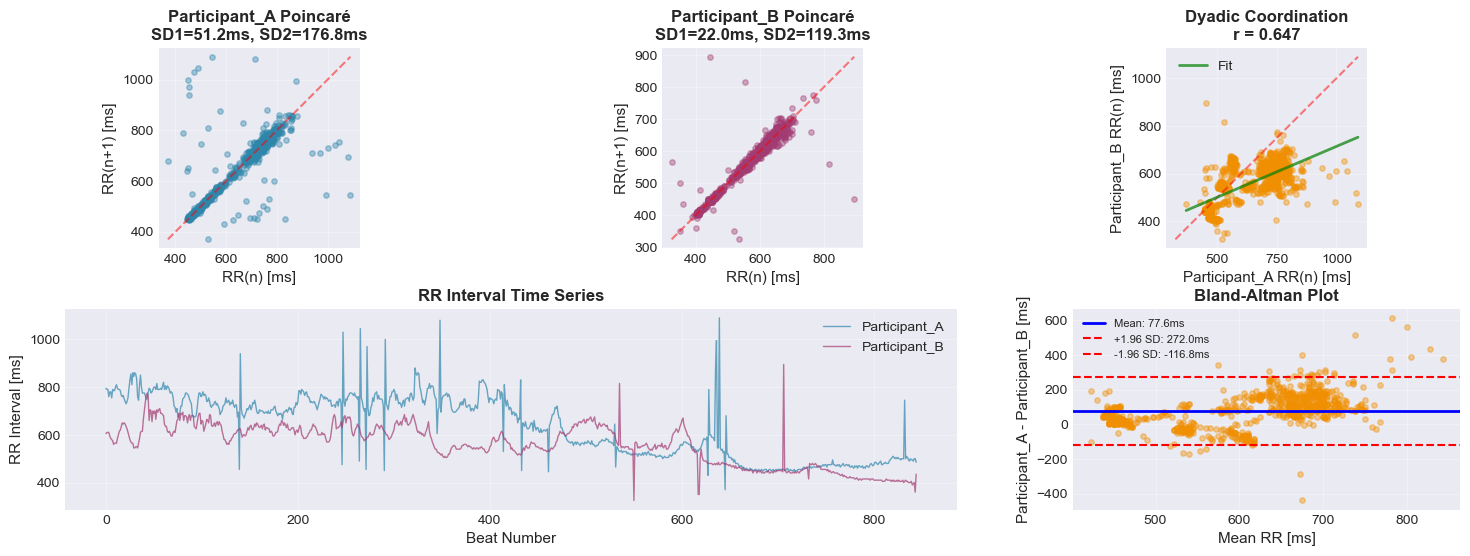

In [5]:
def plot_dyadic_poincare(rr1, rr2, participant_names=('P1', 'P2')):
    """
    Create comprehensive dyadic Poincaré visualization.
    """
    fig = plt.figure(figsize=(18, 6))
    
    # Create grid
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    # Individual Poincaré plots (top row)
    for col, rr, name, color in zip([0, 1], [rr1, rr2], participant_names, ['#2E86AB', '#A23B72']):
        ax = fig.add_subplot(gs[0, col])
        
        if len(rr) > 1:
            ax.scatter(rr[:-1], rr[1:], alpha=0.4, s=15, color=color)
            
            # Identity line
            min_rr, max_rr = rr.min(), rr.max()
            ax.plot([min_rr, max_rr], [min_rr, max_rr], 'r--', alpha=0.5, linewidth=1.5)
            
            # SD1 and SD2
            diff_rr = np.diff(rr)
            sd1 = np.sqrt(np.std(diff_rr, ddof=1) ** 2 * 0.5)
            sd2 = np.sqrt(2 * np.std(rr, ddof=1) ** 2 - 0.5 * np.std(diff_rr, ddof=1) ** 2)
            
            ax.set_xlabel('RR(n) [ms]', fontsize=11)
            ax.set_ylabel('RR(n+1) [ms]', fontsize=11)
            ax.set_title(f'{name} Poincaré\nSD1={sd1:.1f}ms, SD2={sd2:.1f}ms', 
                        fontsize=12, fontweight='bold')
            ax.set_aspect('equal', adjustable='box')
            ax.grid(True, alpha=0.3)
    
    # Dyadic coordination (top right)
    ax = fig.add_subplot(gs[0, 2])
    ax.scatter(rr1, rr2, alpha=0.4, s=15, color='#F18F01')
    
    # Identity line
    min_both = min(rr1.min(), rr2.min())
    max_both = max(rr1.max(), rr2.max())
    ax.plot([min_both, max_both], [min_both, max_both], 'r--', alpha=0.5, linewidth=1.5)
    
    # Regression line
    z = np.polyfit(rr1, rr2, 1)
    p = np.poly1d(z)
    ax.plot(sorted(rr1), p(sorted(rr1)), 'g-', alpha=0.7, linewidth=2, label='Fit')
    
    r = np.corrcoef(rr1, rr2)[0, 1]
    ax.set_xlabel(f'{participant_names[0]} RR(n) [ms]', fontsize=11)
    ax.set_ylabel(f'{participant_names[1]} RR(n) [ms]', fontsize=11)
    ax.set_title(f'Dyadic Coordination\nr = {r:.3f}', fontsize=12, fontweight='bold')
    ax.set_aspect('equal', adjustable='box')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Time series (bottom left, spanning 2 columns)
    ax = fig.add_subplot(gs[1, :2])
    time = np.arange(len(rr1))
    ax.plot(time, rr1, linewidth=1, alpha=0.7, color='#2E86AB', label=participant_names[0])
    ax.plot(time, rr2, linewidth=1, alpha=0.7, color='#A23B72', label=participant_names[1])
    ax.set_xlabel('Beat Number', fontsize=11)
    ax.set_ylabel('RR Interval [ms]', fontsize=11)
    ax.set_title('RR Interval Time Series', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Bland-Altman plot (bottom right)
    ax = fig.add_subplot(gs[1, 2])
    mean_rr = (rr1 + rr2) / 2
    diff_rr = rr1 - rr2
    
    ax.scatter(mean_rr, diff_rr, alpha=0.4, s=15, color='#F18F01')
    
    # Mean difference line
    mean_diff = np.mean(diff_rr)
    ax.axhline(mean_diff, color='b', linestyle='-', linewidth=2, label=f'Mean: {mean_diff:.1f}ms')
    
    # ±1.96 SD lines
    std_diff = np.std(diff_rr)
    ax.axhline(mean_diff + 1.96*std_diff, color='r', linestyle='--', linewidth=1.5, 
               label=f'+1.96 SD: {mean_diff + 1.96*std_diff:.1f}ms')
    ax.axhline(mean_diff - 1.96*std_diff, color='r', linestyle='--', linewidth=1.5,
               label=f'-1.96 SD: {mean_diff - 1.96*std_diff:.1f}ms')
    
    ax.set_xlabel('Mean RR [ms]', fontsize=11)
    ax.set_ylabel(f'{participant_names[0]} - {participant_names[1]} [ms]', fontsize=11)
    ax.set_title('Bland-Altman Plot', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    plt.show()

# Create the plot
plot_dyadic_poincare(
    rr_p1, rr_p2,
    participant_names=(metadata['participant_1'], metadata['participant_2'])
)

Creating overlaid Poincaré ellipse plot...


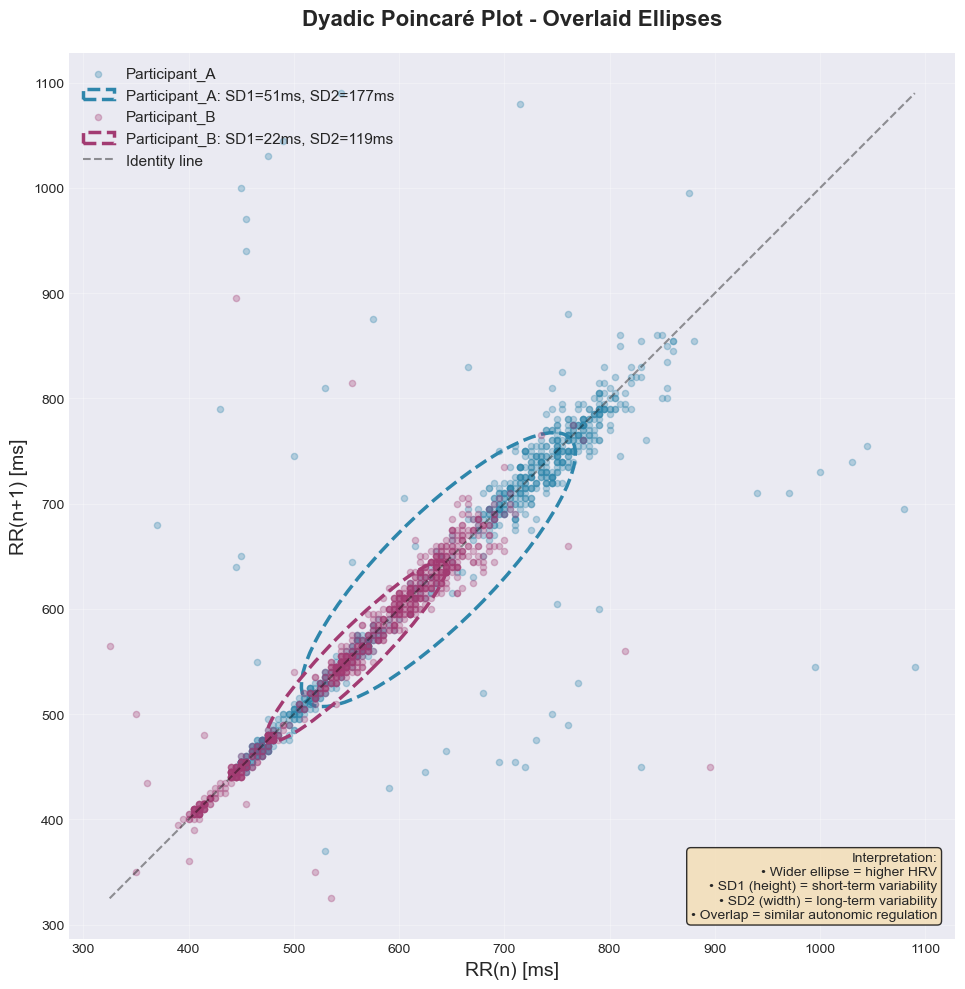

In [7]:
def plot_overlaid_poincare_ellipses(rr1, rr2, participant_names=('P1', 'P2')):
    """
    Create beautiful Poincaré plot with both participants' ellipses overlaid.
    
    This shows individual beat-to-beat variability patterns on the same plot,
    allowing direct visual comparison of autonomic regulation between participants.
    """
    from matplotlib.patches import Ellipse
    import matplotlib.transforms as transforms
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    colors = ['#2E86AB', '#A23B72']
    
    for rr, name, color in zip([rr1, rr2], participant_names, colors):
        if len(rr) > 1:
            # Plot scatter
            ax.scatter(rr[:-1], rr[1:], alpha=0.3, s=20, color=color, label=name)
            
            # Calculate Poincaré indices
            diff_rr = np.diff(rr)
            sd1 = np.sqrt(np.std(diff_rr, ddof=1) ** 2 * 0.5)
            sd2 = np.sqrt(2 * np.std(rr, ddof=1) ** 2 - 0.5 * np.std(diff_rr, ddof=1) ** 2)
            
            # Calculate ellipse parameters
            mean_rr = np.mean(rr)
            
            # Create ellipse
            # SD1 is along the perpendicular to identity line (45° rotated)
            # SD2 is along the identity line
            ellipse = Ellipse(
                (mean_rr, mean_rr),  # Center at mean RR
                width=2*sd2,          # Width along identity line (SD2)
                height=2*sd1,         # Height perpendicular to identity line (SD1)
                angle=45,             # Rotated 45° to align with identity line
                facecolor='none',
                edgecolor=color,
                linewidth=2.5,
                linestyle='--',
                label=f'{name}: SD1={sd1:.0f}ms, SD2={sd2:.0f}ms'
            )
            ax.add_patch(ellipse)
    
    # Add identity line
    all_rr = np.concatenate([rr1, rr2])
    min_rr, max_rr = all_rr.min(), all_rr.max()
    ax.plot([min_rr, max_rr], [min_rr, max_rr], 'k--', alpha=0.4, linewidth=1.5, label='Identity line')
    
    # Labels and formatting
    ax.set_xlabel('RR(n) [ms]', fontsize=14)
    ax.set_ylabel('RR(n+1) [ms]', fontsize=14)
    ax.set_title('Dyadic Poincaré Plot - Overlaid Ellipses', fontsize=16, fontweight='bold', pad=20)
    ax.set_aspect('equal', adjustable='box')
    ax.legend(loc='upper left', fontsize=11, framealpha=0.95)
    ax.grid(True, alpha=0.3)
    
    # Add text box with interpretation
    textstr = '\n'.join([
        'Interpretation:',
        '• Wider ellipse = higher HRV',
        '• SD1 (height) = short-term variability',
        '• SD2 (width) = long-term variability',
        '• Overlap = similar autonomic regulation'
    ])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.98, 0.02, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='bottom', horizontalalignment='right', bbox=props)
    
    plt.tight_layout()
    plt.show()


# Create overlaid ellipse plot
print("Creating overlaid Poincaré ellipse plot...")
plot_overlaid_poincare_ellipses(
    rr_p1, rr_p2,
    participant_names=(metadata['participant_1'], metadata['participant_2'])
)

## 3b. Temporal Evolution: Windowed Dyadic Poincaré Analysis

Now let's see how the dyadic relationship evolves over time by creating a series of plots for different time windows.

WINDOWED DYADIC POINCARÉ ANALYSIS

Creating 17 windows of 30s duration
Overlap: 0s, Step size: 30s


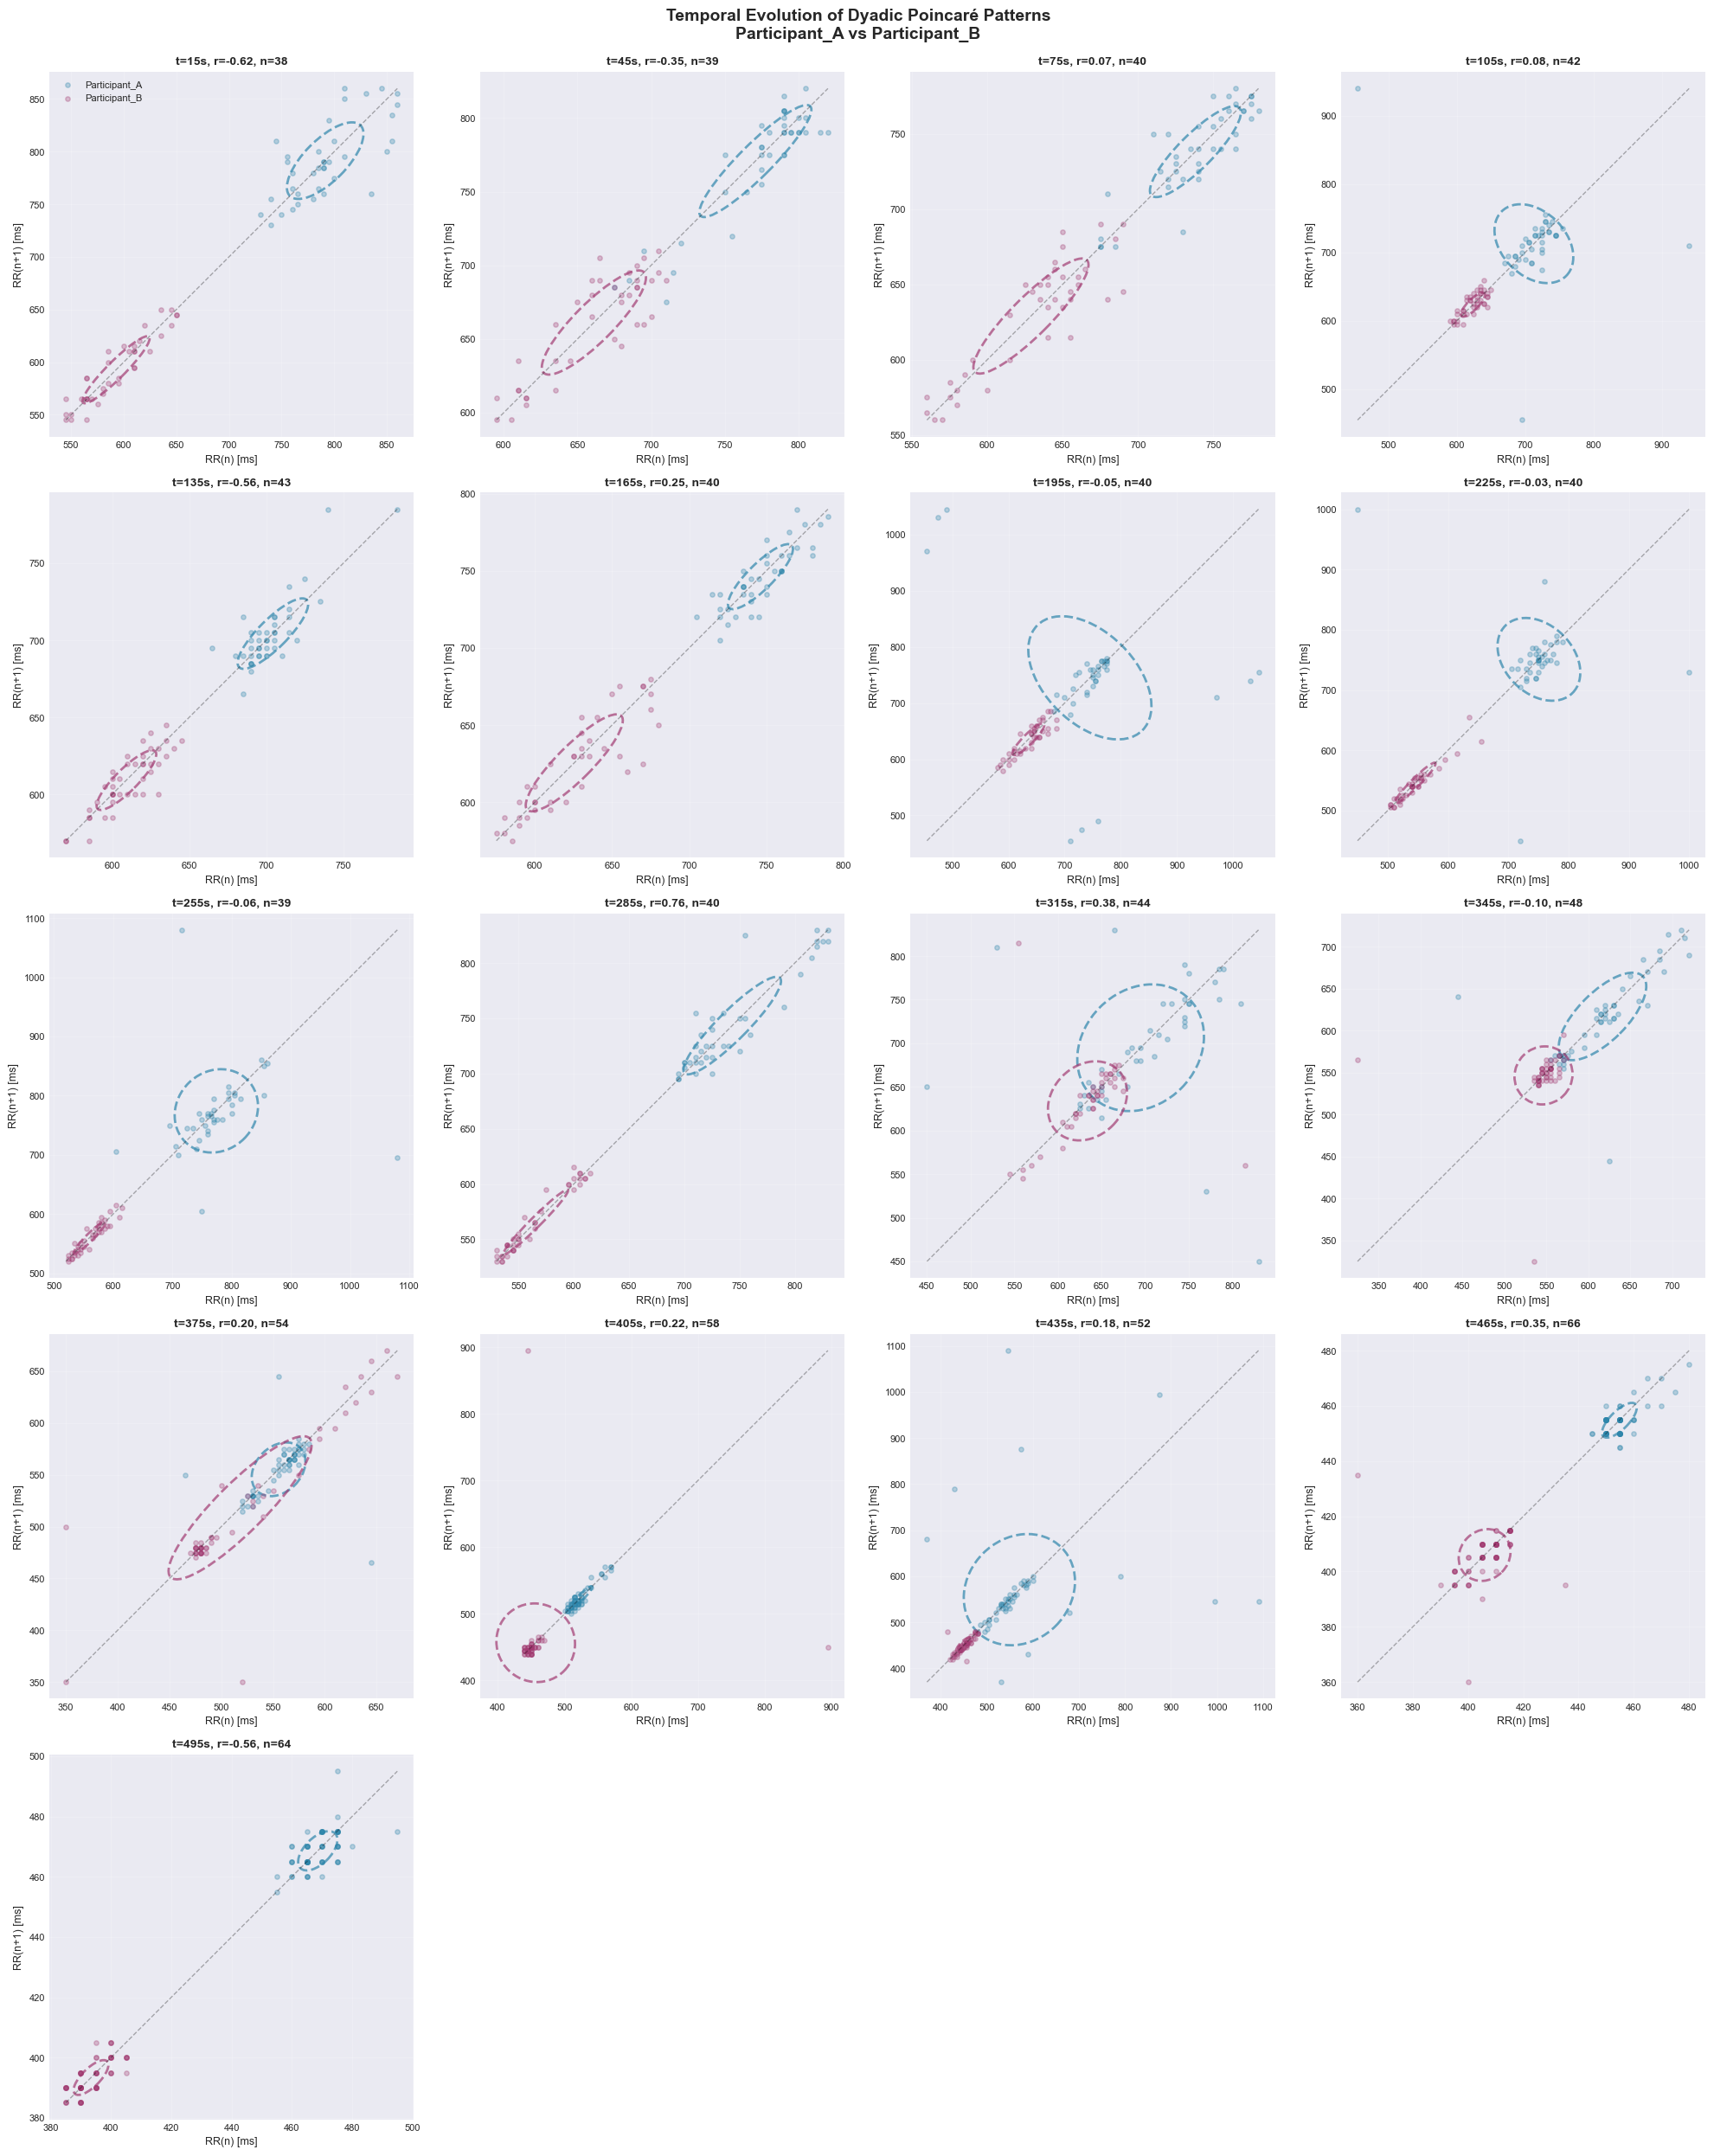


TEMPORAL DYNAMICS SUMMARY

Correlation statistics across windows:
  Mean:   0.009
  Std:    0.370
  Min:    -0.622
  Max:    0.762
  Range:  1.384

Most synchronized period:
  Time: 285s
  Correlation: 0.762

Least synchronized period:
  Time: 15s
  Correlation: -0.622


In [8]:
def windowed_dyadic_poincare(rr1_df, rr2_df, participant_names=('P1', 'P2'), 
                              window_duration_sec=30, overlap_sec=0):
    """
    Create a series of dyadic Poincaré plots over time windows.
    
    Parameters:
    -----------
    rr1_df, rr2_df : DataFrame
        DataFrames with 'Time' and 'RR_interval' columns
    participant_names : tuple
        Names of participants
    window_duration_sec : float
        Duration of each window in seconds
    overlap_sec : float
        Overlap between windows in seconds
        
    Returns:
    --------
    Figure with subplots showing temporal evolution
    """
    from matplotlib.patches import Ellipse
    
    # Extract times and RR intervals
    time_p1 = rr1_df['Time'].values
    time_p2 = rr2_df['Time'].values
    rr1_all = rr1_df['RR_interval'].values
    rr2_all = rr2_df['RR_interval'].values
    
    # Determine time range
    start_time = max(time_p1[0], time_p2[0])
    end_time = min(time_p1[-1], time_p2[-1])
    total_duration = end_time - start_time
    
    # Calculate windows
    step_size = window_duration_sec - overlap_sec
    window_starts = np.arange(start_time, end_time - window_duration_sec, step_size)
    n_windows = len(window_starts)
    
    print(f"Creating {n_windows} windows of {window_duration_sec}s duration")
    print(f"Overlap: {overlap_sec}s, Step size: {step_size}s")
    
    # Calculate subplot layout
    n_cols = min(4, n_windows)
    n_rows = int(np.ceil(n_windows / n_cols))
    
    # Create figure
    fig = plt.figure(figsize=(5*n_cols, 5*n_rows))
    
    colors = ['#2E86AB', '#A23B72']
    
    # Store metrics for summary
    window_metrics = []
    
    for idx, win_start in enumerate(window_starts):
        win_end = win_start + window_duration_sec
        
        # Get RR intervals in this window for both participants
        mask_p1 = (time_p1 >= win_start) & (time_p1 < win_end)
        mask_p2 = (time_p2 >= win_start) & (time_p2 < win_end)
        
        rr1_win = rr1_all[mask_p1]
        rr2_win = rr2_all[mask_p2]
        
        # Ensure same length
        min_len = min(len(rr1_win), len(rr2_win))
        if min_len < 10:  # Skip if too few points
            continue
            
        rr1_win = rr1_win[:min_len]
        rr2_win = rr2_win[:min_len]
        
        # Create subplot
        ax = fig.add_subplot(n_rows, n_cols, idx + 1)
        
        # Plot both participants' Poincaré patterns
        for rr, name, color in zip([rr1_win, rr2_win], participant_names, colors):
            if len(rr) > 1:
                # Scatter
                ax.scatter(rr[:-1], rr[1:], alpha=0.3, s=15, color=color, label=name)
                
                # Calculate SD1 and SD2
                diff_rr = np.diff(rr)
                sd1 = np.sqrt(np.std(diff_rr, ddof=1) ** 2 * 0.5)
                sd2 = np.sqrt(2 * np.std(rr, ddof=1) ** 2 - 0.5 * np.std(diff_rr, ddof=1) ** 2)
                mean_rr = np.mean(rr)
                
                # Draw ellipse
                ellipse = Ellipse(
                    (mean_rr, mean_rr),
                    width=2*sd2,
                    height=2*sd1,
                    angle=45,
                    facecolor='none',
                    edgecolor=color,
                    linewidth=2,
                    linestyle='--',
                    alpha=0.7
                )
                ax.add_patch(ellipse)
        
        # Calculate dyadic correlation
        r = np.corrcoef(rr1_win, rr2_win)[0, 1]
        
        # Identity line
        all_rr = np.concatenate([rr1_win, rr2_win])
        min_rr, max_rr = all_rr.min(), all_rr.max()
        ax.plot([min_rr, max_rr], [min_rr, max_rr], 'k--', alpha=0.3, linewidth=1)
        
        # Formatting
        ax.set_xlabel('RR(n) [ms]', fontsize=9)
        ax.set_ylabel('RR(n+1) [ms]', fontsize=9)
        
        # Title with time and correlation
        win_center = (win_start + win_end) / 2 - start_time
        ax.set_title(f't={win_center:.0f}s, r={r:.2f}, n={min_len}', 
                     fontsize=10, fontweight='bold')
        ax.set_aspect('equal', adjustable='box')
        ax.grid(True, alpha=0.2)
        ax.tick_params(labelsize=8)
        
        if idx == 0:
            ax.legend(fontsize=8, loc='upper left')
        
        # Store metrics
        window_metrics.append({
            'window_start': win_start - start_time,
            'window_center': win_center,
            'correlation': r,
            'n_beats': min_len
        })
    
    plt.suptitle(f'Temporal Evolution of Dyadic Poincaré Patterns\n{participant_names[0]} vs {participant_names[1]}',
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # Return metrics for further analysis
    return pd.DataFrame(window_metrics)

# Create windowed analysis
print("=" * 70)
print("WINDOWED DYADIC POINCARÉ ANALYSIS")
print("=" * 70)
print()

window_metrics = windowed_dyadic_poincare(
    rr_p1_df, rr_p2_df,
    participant_names=(metadata['participant_1'], metadata['participant_2']),
    window_duration_sec=30,
    overlap_sec=0
)

# Display summary statistics
print("\n" + "=" * 70)
print("TEMPORAL DYNAMICS SUMMARY")
print("=" * 70)
print(f"\nCorrelation statistics across windows:")
print(f"  Mean:   {window_metrics['correlation'].mean():.3f}")
print(f"  Std:    {window_metrics['correlation'].std():.3f}")
print(f"  Min:    {window_metrics['correlation'].min():.3f}")
print(f"  Max:    {window_metrics['correlation'].max():.3f}")
print(f"  Range:  {window_metrics['correlation'].max() - window_metrics['correlation'].min():.3f}")

# Find most and least synchronized windows
max_sync_idx = window_metrics['correlation'].idxmax()
min_sync_idx = window_metrics['correlation'].idxmin()

print(f"\nMost synchronized period:")
print(f"  Time: {window_metrics.loc[max_sync_idx, 'window_center']:.0f}s")
print(f"  Correlation: {window_metrics.loc[max_sync_idx, 'correlation']:.3f}")

print(f"\nLeast synchronized period:")
print(f"  Time: {window_metrics.loc[min_sync_idx, 'window_center']:.0f}s")
print(f"  Correlation: {window_metrics.loc[min_sync_idx, 'correlation']:.3f}")

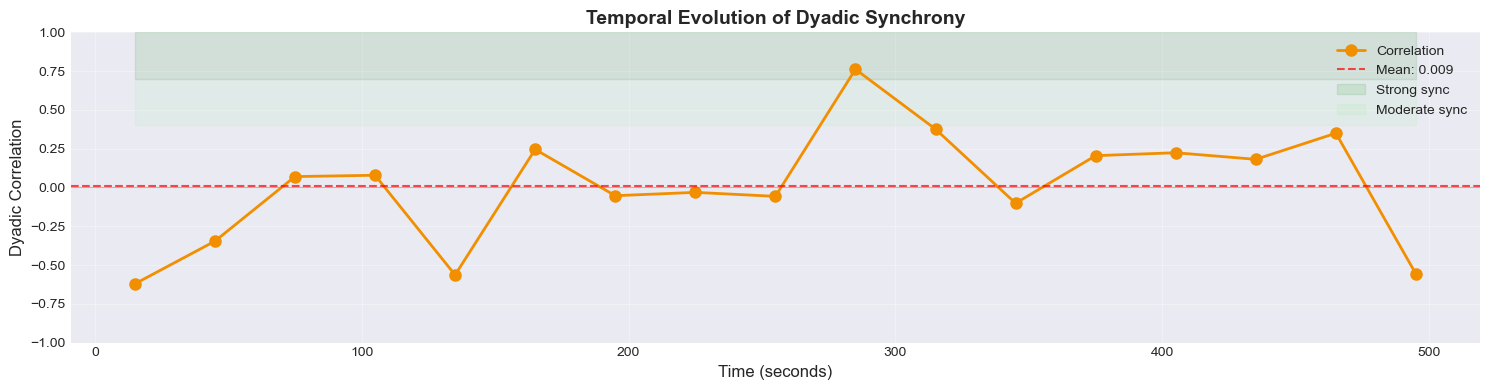


Interpretation:
• Each point represents one 30-second window
• Higher values = stronger dyadic coordination in that period


In [9]:
# Plot correlation over time
fig, ax = plt.subplots(figsize=(15, 4))

ax.plot(window_metrics['window_center'], window_metrics['correlation'], 
        marker='o', linewidth=2, markersize=8, color='#F18F01', label='Correlation')

# Add reference lines
ax.axhline(0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
ax.axhline(window_metrics['correlation'].mean(), color='red', linestyle='--', 
           linewidth=1.5, alpha=0.7, label=f"Mean: {window_metrics['correlation'].mean():.3f}")

# Shade regions by strength
ax.fill_between(window_metrics['window_center'], 0.7, 1.0, alpha=0.1, color='green', label='Strong sync')
ax.fill_between(window_metrics['window_center'], 0.4, 0.7, alpha=0.1, color='lightgreen', label='Moderate sync')

ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('Dyadic Correlation', fontsize=12)
ax.set_title('Temporal Evolution of Dyadic Synchrony', fontsize=14, fontweight='bold')
ax.set_ylim(-1, 1)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("• Each point represents one 30-second window")
print("• Higher values = stronger dyadic coordination in that period")

## 4. Leader-Follower Analysis

### Detecting Directionality

Multiple approaches to identify who influences whom:

1. **Cross-correlation lag**: Peak at positive lag → P1 leads
2. **Lag-1 autocorrelations**: Which direction is stronger?
3. **Granger causality**: Statistical test of predictive power
4. **Phase directionality**: Who's phase leads?

In [10]:
def leader_follower_analysis(x, y, sampling_rate=4, max_lag_s=10):
    """
    Comprehensive leader-follower analysis.
    
    Parameters:
    -----------
    x, y : array
        Time series for participants 1 and 2
    sampling_rate : float
        Sampling rate in Hz
    max_lag_s : float
        Maximum lag to test (seconds)
        
    Returns:
    --------
    dict with multiple directionality measures
    """
    # Ensure same length
    min_len = min(len(x), len(y))
    x = x[:min_len]
    y = y[:min_len]
    
    results = {}
    
    # 1. Cross-correlation with lag
    max_lag = int(max_lag_s * sampling_rate)
    x0 = x - np.nanmean(x)
    y0 = y - np.nanmean(y)
    x0 = np.nan_to_num(x0)
    y0 = np.nan_to_num(y0)
    
    corr = correlate(x0, y0, mode='full', method='fft')
    lags = np.arange(-len(x0) + 1, len(x0))
    
    mask = (lags >= -max_lag) & (lags <= max_lag)
    corr = corr[mask]
    lags = lags[mask]
    
    denom = np.sqrt(np.sum(x0**2) * np.sum(y0**2))
    if denom > 0:
        corr_norm = corr / denom
    else:
        corr_norm = corr
    
    peak_idx = int(np.nanargmax(np.abs(corr_norm)))
    results['xcorr_peak'] = float(corr_norm[peak_idx])
    results['xcorr_lag_s'] = float(lags[peak_idx] / sampling_rate)
    
    # 2. Directed lag-1 correlations
    if len(x) > 2:
        # X(t) predicts Y(t+1)
        r_x_to_y = np.corrcoef(x[:-1], y[1:])[0, 1]
        # Y(t) predicts X(t+1)
        r_y_to_x = np.corrcoef(y[:-1], x[1:])[0, 1]
        
        results['lag1_x_to_y'] = float(r_x_to_y)
        results['lag1_y_to_x'] = float(r_y_to_x)
        results['lag1_asymmetry'] = float(r_x_to_y - r_y_to_x)
    else:
        results['lag1_x_to_y'] = np.nan
        results['lag1_y_to_x'] = np.nan
        results['lag1_asymmetry'] = np.nan
    
    # 3. Phase directionality
    try:
        phase_x = np.angle(hilbert(x0))
        phase_y = np.angle(hilbert(y0))
        
        # Instantaneous phase difference
        phase_diff = phase_x - phase_y
        
        # Mean phase difference (circular mean)
        mean_phase_diff = np.angle(np.mean(np.exp(1j * phase_diff)))
        
        results['mean_phase_diff'] = float(mean_phase_diff)
        
        # If positive: X leads; if negative: Y leads
        results['phase_leader'] = 'X' if mean_phase_diff > 0 else 'Y'
        
    except:
        results['mean_phase_diff'] = np.nan
        results['phase_leader'] = None
    
    # 4. Determine overall leader
    evidence = []
    
    if results['xcorr_lag_s'] > 1:  # X leads by >1s
        evidence.append('X')
    elif results['xcorr_lag_s'] < -1:  # Y leads by >1s
        evidence.append('Y')
    
    if abs(results.get('lag1_asymmetry', 0)) > 0.05:
        evidence.append('X' if results['lag1_asymmetry'] > 0 else 'Y')
    
    if results.get('phase_leader'):
        evidence.append(results['phase_leader'])
    
    if evidence:
        # Majority vote
        x_votes = evidence.count('X')
        y_votes = evidence.count('Y')
        
        if x_votes > y_votes:
            results['overall_leader'] = 'X'
            results['leader_confidence'] = x_votes / len(evidence)
        elif y_votes > x_votes:
            results['overall_leader'] = 'Y'
            results['leader_confidence'] = y_votes / len(evidence)
        else:
            results['overall_leader'] = 'SYMMETRIC'
            results['leader_confidence'] = 0.5
    else:
        results['overall_leader'] = 'UNCLEAR'
        results['leader_confidence'] = 0.0
    
    return results

print(" Leader-follower analysis function loaded")

 Leader-follower analysis function loaded


In [11]:
# Prepare heart rate data
hr1_data = hr_p1['HeartRate'].values
hr2_data = hr_p2['HeartRate'].values

# Standardize
hr1_std = stats.zscore(hr1_data[:min_len])
hr2_std = stats.zscore(hr2_data[:min_len])

# Run analysis
lf_results = leader_follower_analysis(hr1_std, hr2_std, sampling_rate=4, max_lag_s=10)

print("=" * 70)
print("LEADER-FOLLOWER ANALYSIS")
print("=" * 70)

print(f"\n1. Cross-Correlation:")
print(f"   Peak correlation: {lf_results['xcorr_peak']:.3f}")
print(f"   Lag: {lf_results['xcorr_lag_s']:.2f}s")
if lf_results['xcorr_lag_s'] > 1:
    print(f"   → {metadata['participant_1']} LEADS {metadata['participant_2']}")
elif lf_results['xcorr_lag_s'] < -1:
    print(f"   → {metadata['participant_2']} LEADS {metadata['participant_1']}")
else:
    print(f"   → SYNCHRONOUS (no clear lag)")

print(f"\n2. Lag-1 Directed Correlations:")
print(f"   {metadata['participant_1']} → {metadata['participant_2']}: {lf_results['lag1_x_to_y']:.3f}")
print(f"   {metadata['participant_2']} → {metadata['participant_1']}: {lf_results['lag1_y_to_x']:.3f}")
print(f"   Asymmetry: {lf_results['lag1_asymmetry']:.3f}")
if abs(lf_results['lag1_asymmetry']) > 0.05:
    if lf_results['lag1_asymmetry'] > 0:
        print(f"   → {metadata['participant_1']} influences {metadata['participant_2']}'s next beat more")
    else:
        print(f"   → {metadata['participant_2']} influences {metadata['participant_1']}'s next beat more")

print(f"\n3. Phase Directionality:")
print(f"   Mean phase difference: {lf_results['mean_phase_diff']:.3f} rad")
if lf_results['phase_leader'] == 'X':
    print(f"   → {metadata['participant_1']}'s phase tends to lead")
elif lf_results['phase_leader'] == 'Y':
    print(f"   → {metadata['participant_2']}'s phase tends to lead")

print(f"\n4. OVERALL CONCLUSION:")
print(f"   Leader: {lf_results['overall_leader']}")
print(f"   Confidence: {lf_results['leader_confidence']:.1%}")

if lf_results['overall_leader'] == 'X':
    print(f"   → {metadata['participant_1']} tends to LEAD the dyadic interaction")
elif lf_results['overall_leader'] == 'Y':
    print(f"   → {metadata['participant_2']} tends to LEAD the dyadic interaction")
elif lf_results['overall_leader'] == 'SYMMETRIC':
    print(f"   → BIDIRECTIONAL/SYMMETRIC coupling (no clear leader)")
else:
    print(f"   → Evidence is UNCLEAR - may need longer recording or different conditions")

LEADER-FOLLOWER ANALYSIS

1. Cross-Correlation:
   Peak correlation: 0.255
   Lag: -6.75s
   → Participant_B LEADS Participant_A

2. Lag-1 Directed Correlations:
   Participant_A → Participant_B: 0.108
   Participant_B → Participant_A: 0.086
   Asymmetry: 0.022

3. Phase Directionality:
   Mean phase difference: 1.040 rad
   → Participant_A's phase tends to lead

4. OVERALL CONCLUSION:
   Leader: SYMMETRIC
   Confidence: 50.0%
   → BIDIRECTIONAL/SYMMETRIC coupling (no clear leader)


## 5. Granger Causality Test (Optional)

### What is Granger Causality?

Tests whether past values of X help predict future values of Y, beyond what Y's own past predicts.

**"X Granger-causes Y"** means: knowing X's history improves predictions of Y

**Important**: "Granger causality" ≠ true causality! It's about predictive relationships.

In [12]:
def granger_causality_analysis(x, y, max_lag=5):
    """
    Test Granger causality in both directions.
    
    Parameters:
    -----------
    x, y : array
        Time series
    max_lag : int
        Maximum lag to test
        
    Returns:
    --------
    dict with test results
    """
    if not GRANGER_AVAILABLE:
        return {'available': False, 'message': 'statsmodels not installed'}
    
    # Ensure same length
    min_len = min(len(x), len(y))
    x = x[:min_len]
    y = y[:min_len]
    
    results = {'available': True}
    
    try:
        # Test X → Y
        data_xy = np.column_stack([y, x])
        gc_xy = grangercausalitytests(data_xy, max_lag, verbose=False)
        
        # Extract p-values for each lag
        p_vals_xy = [gc_xy[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
        results['x_to_y_pvals'] = p_vals_xy
        results['x_to_y_significant'] = any(p < 0.05 for p in p_vals_xy)
        results['x_to_y_min_pval'] = float(min(p_vals_xy))
        
        # Test Y → X
        data_yx = np.column_stack([x, y])
        gc_yx = grangercausalitytests(data_yx, max_lag, verbose=False)
        
        p_vals_yx = [gc_yx[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
        results['y_to_x_pvals'] = p_vals_yx
        results['y_to_x_significant'] = any(p < 0.05 for p in p_vals_yx)
        results['y_to_x_min_pval'] = float(min(p_vals_yx))
        
        # Determine directionality
        if results['x_to_y_significant'] and not results['y_to_x_significant']:
            results['granger_direction'] = 'X → Y'
        elif results['y_to_x_significant'] and not results['x_to_y_significant']:
            results['granger_direction'] = 'Y → X'
        elif results['x_to_y_significant'] and results['y_to_x_significant']:
            results['granger_direction'] = 'BIDIRECTIONAL'
        else:
            results['granger_direction'] = 'NONE'
            
    except Exception as e:
        results['error'] = str(e)
        results['granger_direction'] = 'ERROR'
    
    return results

if GRANGER_AVAILABLE:
    print("Running Granger causality tests...")
    granger_results = granger_causality_analysis(hr1_std, hr2_std, max_lag=5)
    
    print("\n" + "=" * 70)
    print("GRANGER CAUSALITY ANALYSIS")
    print("=" * 70)
    
    print(f"\n{metadata['participant_1']} → {metadata['participant_2']}:")
    print(f"   Significant: {granger_results['x_to_y_significant']}")
    print(f"   Min p-value: {granger_results['x_to_y_min_pval']:.4f}")
    
    print(f"\n{metadata['participant_2']} → {metadata['participant_1']}:")
    print(f"   Significant: {granger_results['y_to_x_significant']}")
    print(f"   Min p-value: {granger_results['y_to_x_min_pval']:.4f}")
    
    print(f"\nConclusion: {granger_results['granger_direction']}")
    
else:
    print("\n Skipping Granger causality (statsmodels not available)")
    print("   Install with: pip install statsmodels")

Running Granger causality tests...

GRANGER CAUSALITY ANALYSIS

Participant_A → Participant_B:
   Significant: True
   Min p-value: 0.0140

Participant_B → Participant_A:
   Significant: True
   Min p-value: 0.0030

Conclusion: BIDIRECTIONAL


## 6. Save Results

In [13]:
# Combine all results
all_results = {
    'session_info': {
        'participant_1': metadata['participant_1'],
        'participant_2': metadata['participant_2'],
        'duration_s': metadata['duration_seconds'],
        'n_beats': len(rr_p1)
    },
    'dyadic_poincare': poincare_results,
    'leader_follower': lf_results
}

if GRANGER_AVAILABLE and 'granger_results' in locals():
    all_results['granger'] = granger_results

# Save to JSON
output_dir = Path("/Users/lena/Downloads/tutorial_dyadic_movesense/analysis_results")
output_dir.mkdir(exist_ok=True)

import json
with open(output_dir / 'dyadic_analysis_results.json', 'w') as f:
    json.dump(all_results, f, indent=2)

print(f"✓ Results saved to {output_dir}/dyadic_analysis_results.json")

✓ Results saved to /Users/lena/Downloads/tutorial_dyadic_movesense/analysis_results/dyadic_analysis_results.json


---

## Summary

This notebook provided specialized dyadic analyses:

### What We Computed:

1. **Dyadic Poincaré Analysis**
   - Individual beat-to-beat variability (SD1, SD2)
   - Dyadic coordination strength
   - Difference metrics (Bland-Altman)

2. **Leader-Follower Analysis**
   - Cross-correlation lag
   - Lag-1 directed correlations
   - Phase directionality
   - Overall leader determination

3. **Granger Causality** (optional)
   - Statistical test of predictive relationships
   - Bidirectional testing

### Interpretation Guide:

**Strong Leader:**
- Large cross-correlation lag (>2s)
- Asymmetric lag-1 correlations (>0.1 difference)
- Consistent phase lead
- Significant Granger causality in one direction

**Symmetric Coupling:**
- Near-zero lag (<1s)
- Similar lag-1 correlations
- Bidirectional Granger causality

**Weak/No Coupling:**
- Low overall correlation (<0.3)
- Inconsistent evidence across methods
- Non-significant Granger tests

### Research Applications:

- **Therapy**: Does therapist lead client's arousal regulation?
- **Parent-child**: How does co-regulation develop?
- **Romantic partners**: Who initiates physiological changes?
- **Teams**: Identify natural leaders in collaboration

---

**Combined with Notebook 4, you now have a complete cardiac synchrony analysis toolkit! **